# Analysis of our data

Our aim is to explore the relations that exist between the social and economic status of the French population and the quality of the food that is available. 

Indeed, we start from a point where we believe there is a correlation between obesity and socio-economic level: poor people tend to be more overweight than their richer counterparts. Moreover, obesity has been linked with the consumption of food items that have high rates of sugar, fat and energy.

We wish to explore a possible intermediate link between obesity and socio-economic level: the quality of the available food. 

Our dataframe includes labelled products, their nutritional information, a few nutritional scores and the places where these products are sold. We have coupled this data with economical and social data from French cities in order to obtain a clean dataframe containing for each row:
- a product identifier
- its nutritional information
- the city where it is sold (if sold in several cities, the row is duplicated)
- the median revenue, mean revenue, poverty rate and other economic features relative to the city

In order to analyse our data, we have proceeded in several steps:

1. Exploration of the distribution of the nutrition grades at each geographical level for the richest and poorest zone

2. Distribution of the product frequency according to their nutrition grade

3. Implementation of two additional custom nutrition scores

4. Dimensionality reduction

5. Data aggregation according to a certain geographical level (city, arrondissement, department or region)

6. Attempt at clustering

7. Correlation exploration

8. Geographic visualisation

In [2]:
import findspark
import os
findspark.init(os.environ['SPARK_HOME'])

import folium
from IPython.core.display import display, HTML
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql import *
from pyspark.sql.functions import *
import re
import scipy as sp
from scipy import stats
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from termcolor import colored

%matplotlib inline

spark = SparkSession.builder.getOrCreate()

In [3]:
dataframe = pd.read_csv('../data/processed/clean_food_cities_arrond_with_tax.csv')
dataframe = dataframe.drop(columns=['Unnamed: 0'])
dataframe.head()

C:\Users\zouag\Anaconda3\envs\ADA\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Number of fiscal households,Number of taxed households,Mean reference fiscal income (in k€),food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,...,Poverty rate (tenants) (%),Share of activity revenue (%),Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City,Department,Region,Arrondissement
0,206,108,27.468762,431441,16.0,16.0,4,NaN,883.0,12.00,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
1,206,108,27.468762,348749,15.0,15.0,4,NaN,703.0,9.30,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
2,206,108,27.468762,348720,16.0,16.0,4,NaN,900.0,12.00,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
3,206,108,27.468762,348741,11.0,11.0,4,50 g (1 tranche),514.0,3.66,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004
4,206,108,27.468762,348708,15.0,15.0,4,Une tranche 100 g,699.0,9.40,...,NaN,NaN,NaN,NaN,NaN,NaN,Apremont,10,84,1004


# 1. Distribution of the nutrition grades at each geographical level for the richest and poorest zone

In [4]:
def analyse_for_area(df, area_column, area_name):
    """Display the distribution of the numeric nutrition grade for the richest and poorest area
    
    Arguments:
    ----------
    df: pandas.DataFrame
        The dataframe containing the needed information.
    area_column: string
        Name of the column containing the information about the area.
    area_name: string
        Name of the area.
    """
    revenue = df.groupby(area_column).mean().sort_values(by=['Median revenue euros'], ascending=False)
    rich = revenue.iloc[[0]]
    rich.reset_index(inplace=True)
    poor = revenue.iloc[[-1]]
    poor.reset_index(inplace=True)
    
    departments = [list(rich[area_column].values)[0], list(poor[area_column].values)[0]]
    list_dummy_grades = ['nutrition_grade_numeric_0', 'nutrition_grade_numeric_1',
                     'nutrition_grade_numeric_2', 'nutrition_grade_numeric_3',
                     'nutrition_grade_numeric_4', 'nutrition_grade_numeric_5']
    
    dummies = pd.get_dummies(df, columns=['nutrition_grade_numeric']).groupby(area_column).sum()
    dummies.reset_index(inplace=True)
    dummies = dummies[dummies[area_column].apply(lambda x: x in departments)][list_dummy_grades]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle("Distribution of the nutrition grades' frequencies for the richest and the poorest {}".format(area_name),
                 y=1.08, fontweight="bold")
    dummies.iloc[[0]].plot.bar(ax=ax1, use_index=False, xticks=[0, 1, 2, 3, 4, 5])
    dummies.iloc[[1]].plot.bar(ax=ax2, use_index=False, xticks=[0, 1, 2, 3, 4, 5])
    ax1.set_title("Rich {}".format(area_name))
    ax2.set_title("Poor {}".format(area_name))

    plt.show()

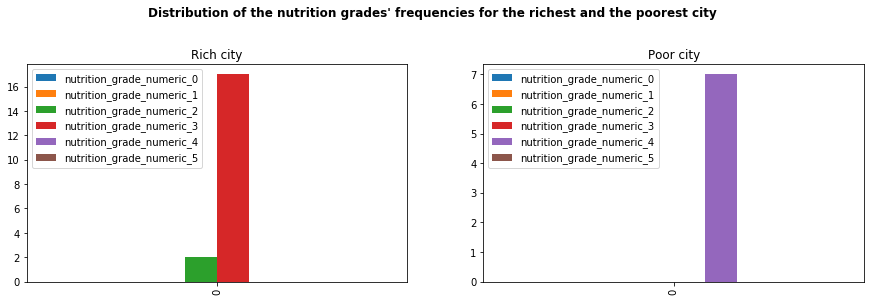

In [5]:
analyse_for_area(dataframe, 'City', 'city')

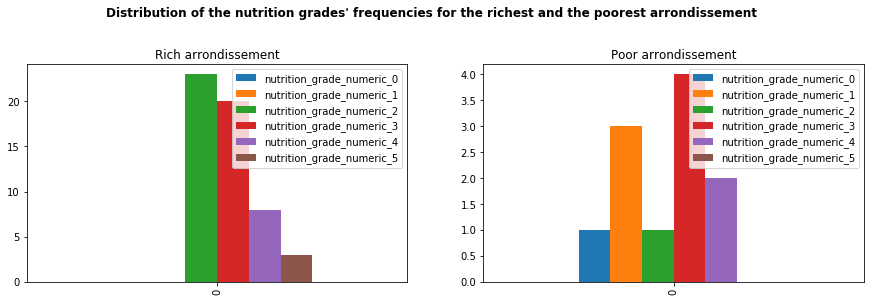

In [6]:
analyse_for_area(dataframe, 'Arrondissement', 'arrondissement')

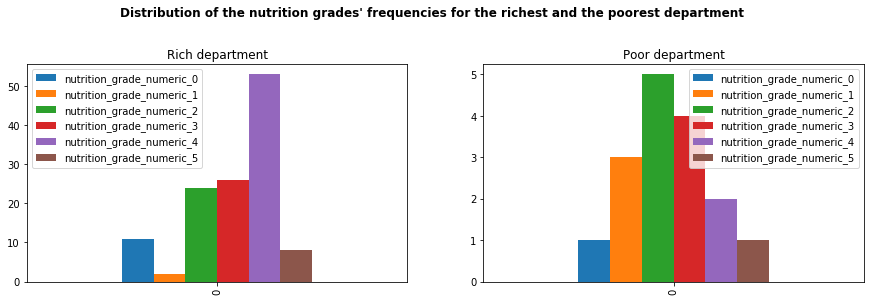

In [7]:
analyse_for_area(dataframe, 'Department', 'department')

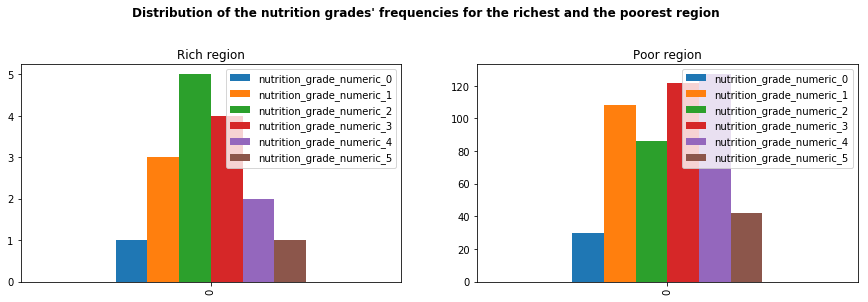

In [8]:
analyse_for_area(dataframe, 'Region', 'region')

We see that rich and poor areas can have very different distribution of the healthiness of the available products.
However, we cannot tell 

# 2. Distribution of the products per nutrition grade

* Nutrition grade has integer values between 1 and 5, 1 indicating healthy food items and 5 describing unhealthy items.

* Nutrition score (UK or Fr.) has values between -15 and 40. -15 indicates a healthy food item, 40 indicates an unhealthy food item. 

The correspondence between the two of them for solid foods is:

* Nutrition grade = 1 : nutrition score $\in [-15, : -1]$
* Nutrition grade = 2 : nutrition score $\in [0, 2]$
* Nutrition grade = 3 : nutrition score $\in [3, 10]$
* Nutrition grade = 4 : nutrition score $\in [11, 18]$
* Nutrition grade = 5 : nutrition score $\in [19, 40]$

The correspondence between the two of them for beverages is:

* Nutrition grade = 1 : Water
* Nutrition grade = 2 : nutrition score $\in [-15, 1]$
* Nutrition grade = 3 : nutrition score $\in [2, 5]$
* Nutrition grade = 4 : nutrition score $\in [6, 9]$
* Nutrition grade = 5 : nutrition score $\in [10, 40]$

https://fr.openfoodfacts.org/nutriscore

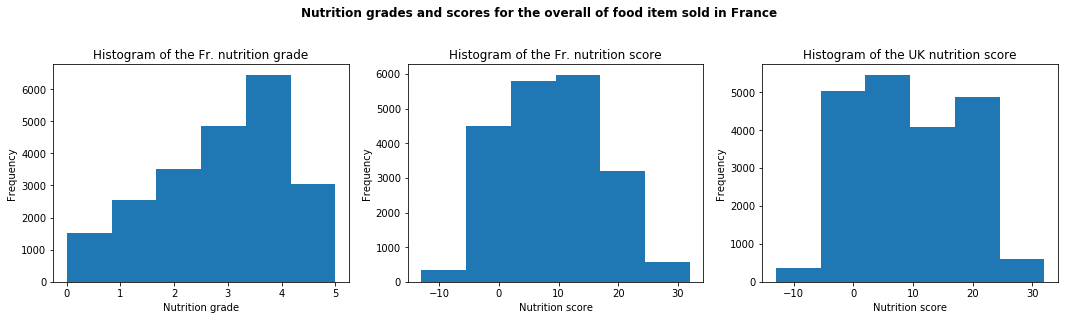

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
f.suptitle("Nutrition grades and scores for the overall of food item sold in France", 
           y=1.08, fontweight="bold")
dataframe['nutrition_grade_numeric'].plot.hist(bins=6, ax=ax1)
ax1.set_title("Histogram of the Fr. nutrition grade")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Nutrition grade")

dataframe['nutrition-score-fr_100g'].plot.hist(bins=6, ax=ax2)
ax2.set_title("Histogram of the Fr. nutrition score")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("Nutrition score")

dataframe['nutrition-score-uk_100g'].plot.hist(bins=6, ax=ax3)
ax3.set_title("Histogram of the UK nutrition score")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("Nutrition score")
plt.show()

*Reminder: `0` is equivalent to no data.*

When we look at the nutrition grade histogram, we see that most of the products are labeled with a `3` or below, which indicates that healthy products are rare in comparison. 

When looking at the nutrition score histograms, the lack of healthy products is reinforced, however there are also a lot less **very** unhealthy products.

Since these 3 columns in our dataframe describe the same thing, we need to choose one. Intuitively, we would choose Nutrition grade because it already gives us a judgement on the quality of the food independently on if the item is solid food or beverage. 

We will however introduce two more nutrition metrics, and after that we will select only the relevant columns in our dataframe (i.e. columns that don't have the **exact same information**, columns that are not **redundant**, or columns that have **enough non NaN values**). 

# 3. Implementation of custom nutrition scores

We introduce two more nutrition scores: calory density (the calories per serving size) and calory deviation.

Calory deviation is computed according to the nutritional standards that the calories that we consume in a day should be composed of $21 \%$ from protein, $53 \%$ from carbohydrates and $26 \%$ from fat [(2010 Dietary Guidelines for Americans table 2-4)](https://health.gov/dietaryguidelines/dga2010/dietaryguidelines2010.pdf). We then compute a deviation from this standard for each product. 

* In the first case (calory density), the metric describes how largely a product is packed with calories. Since obesity is linked with the amount of calories in the ingested food items, this metric might be useful.

* In the second case (calory deviation), we aim at observing whether the products follow a healthy calory distribution. This metric (RMSE) would show us if a certain region has bad nutrition habits with respect to the ratios of nutriments they should eat. 

In [10]:
# we consider only the energy per 100g and the serving size
cals = dataframe[['energy_100g', 'serving_size']]
# we drop nan values, and serving sizes that are not relevant
cals = cals.dropna()
cals = cals.drop(cals[cals['serving_size'].str.contains("mg")].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('oeuf')].index)
cals = cals.drop(cals[cals['serving_size'].str.contains('Deux tranches g')].index)
# we keep only the number of units of the usual measure unit for the product
cal = cals['serving_size'].str.replace('.*?(?P<number>[0-9.,]+)\s*(G|g|f|ml|mL).*', '\\g<number>')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(cl|cL).*', '\\g<number>0')
cal = cal.str.replace('.*?(?P<number>[0-9.,]+)\s*(Kg|L|l).*', '\\g<number>000')
# we remove values that are composed only of letters
cal = cal.str.replace('[^0-9]+', '')
cal = cal.replace('', np.nan)
cal = cal.dropna()
# we cast everything to float
cal = cal.str.replace(",", ".").astype('float')
cals.serving_size = cal
# and reinsert it in our dataframe
dataframe.loc[:, 'serving_size'] = cal

cal_density = cals.serving_size * cals.energy_100g / 100

**Note**

Proteins --> 21% of cals, 4 cals/g

Carbohydrates --> 53% of cals, 4 cals/g

Fat --> 26% of cals, 9 cals/g

In [11]:
# energy has to be divided by 4.184 to convert from Joules to kilocalories
energy_in_kcal_100g = dataframe.energy_100g / 4.184
cal_deviation = ((dataframe.fat_100g * 9 / energy_in_kcal_100g - 0.26)**2 + 
                (dataframe.carbohydrates_100g * 4 / energy_in_kcal_100g - 0.53)**2 +
                (dataframe.proteins_100g * 4 / energy_in_kcal_100g - 0.21)**2)/3
# we remove unknown and infinite values
cal_deviation.replace(np.infty, np.nan, inplace=True)
cal_deviation.dropna(inplace=True)
cal_deviation.describe()

count    21376.000000
mean         5.766193
std        563.562554
min          0.000044
25%          0.017735
50%          0.078327
75%          0.160257
max      58205.149533
dtype: float64

In [12]:
# we insert our columns in our dataframe
dataframe.loc[:, 'cal_density'] = cal_density
dataframe.loc[:, 'cal_deviation'] = cal_deviation
dataframe.head()

,Number of fiscal households,Number of taxed households,Mean reference fiscal income (in k€),food_item_index,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,...,Share of retreat pension revenue (%),Share of heritage revenue and other (%),Share of social benefits revenue (%),Share of taxes (%),City,Department,Region,Arrondissement,cal_density,cal_deviation
0,206,108,27.468762,431441,16.0,16.0,4,NaN,883.0,12.00,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,NaN,0.133987
1,206,108,27.468762,348749,15.0,15.0,4,NaN,703.0,9.30,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,NaN,0.116812
2,206,108,27.468762,348720,16.0,16.0,4,NaN,900.0,12.00,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,NaN,0.130923
3,206,108,27.468762,348741,11.0,11.0,4,50.0,514.0,3.66,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,257.0,0.157268
4,206,108,27.468762,348708,15.0,15.0,4,100.0,699.0,9.40,...,NaN,NaN,NaN,NaN,Apremont,10,84,1004,699.0,0.117324


# 4. Decide which columns to keep

In [13]:
numeric_cols = ['Number of fiscal households', 'Number of taxed households', 
                'Mean reference fiscal income (in k€)', 'food_item_index', 'nutrition-score-fr_100g', 
                'nutrition-score-uk_100g','nutrition_grade_numeric', 'serving_size', 'energy_100g', 
                'fat_100g','saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g','sugars_100g', 
                'fiber_100g', 'Median revenue euros','Total poverty rate (%)', 'Poverty rate (-30) (%)',
               'Poverty rate (30-39) (%)', 'Poverty rate (40-49) (%)',
               'Poverty rate (50-59) (%)', 'Poverty rate (60-74) (%)',
               'Poverty rate (75+) (%)', 'Poverty rate (house owners) (%)',
               'Poverty rate (tenants) (%)', 'Share of activity revenue (%)',
               'Share of retreat pension revenue (%)',
               'Share of heritage revenue and other (%)',
               'Share of social benefits revenue (%)', 'Share of taxes (%)',
               'cal_density', 'cal_deviation']

In [26]:
for column in numeric_cols:
    nonna = len(dataframe[dataframe[column].apply(lambda x: not np.isnan(x))]) / len(dataframe)
    print('{:<45s}{:<30s}{:<55.1f%}'.format(column, 'Number of non-na:', nonna))

Number of fiscal households                  Number of non-na:             100.000000%                                            
Number of taxed households                   Number of non-na:             100.000000%                                            
Mean reference fiscal income (in k€)         Number of non-na:             100.000000%                                            
food_item_index                              Number of non-na:             100.000000%                                            
nutrition-score-fr_100g                      Number of non-na:             93.127226%                                             
nutrition-score-uk_100g                      Number of non-na:             93.127226%                                             
nutrition_grade_numeric                      Number of non-na:             100.000000%                                            
serving_size                                 Number of non-na:             55.44798

We decided to keep all nutritional columns and all economical columns that have at least $90 \%$ of non NaN values. Indeed, all nutritional columns are probably useful for our analysis, however if we keep economical columns that have a lot of NaN values within them, we will lose information when we use dropna(). Moreover, we assume that the informaiton about the revenue conveys all the economical information we need (since it is closely linked with all the other economic features such as poverty rate, etc).

We also decided to drop the column 'Number of taxed households" because it seems to be redundant with respect to 'Number of fiscal households'. 

This leaves us with:

* 1 column describing the food item's identifier:
    - food item index

* 11 columns describing nutritional features:
    - nutrition-score-fr_100g            
    - nutrition-score-uk_100g            
    - nutrition_grade_numeric           
    - serving_size           
    - energy_100g                        
    - fat_100g                           
    - saturated-fat_100g                 
    - proteins_100g                      
    - carbohydrates_100g                 
    - sugars_100g                        
    - fiber_100g

* 3 columns describing economic features: 
    - Median revenue euros
    - Mean reference fiscal income (in k€) 
    - Number of fiscal households
    
* 4 columns describing geographical features
    - City
    - Arrondissement
    - Department
    - Region

In [35]:
dataframe = dataframe[['food_item_index', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                       'nutrition_grade_numeric', 'serving_size', 'energy_100g', 'fat_100g',
                       'saturated-fat_100g', 'proteins_100g', 'carbohydrates_100g',
                       'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation', 
                       'Median revenue euros', 'Mean reference fiscal income (in k€)', 'Number of fiscal households', 
                       'Number of taxed households', 'City', 'Department', 
                       'Region', 'Arrondissement']]

**2. Mutual Information**

Now that we have the important elements from the two datasets we can aplly feature reduction using mutual information, this measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. We thought also about using PCA but as we are looking into selecting features from our original data, MI gives an easier interpretation of the dependencies.

In [36]:
new_df = dataframe.drop(columns=['food_item_index','Department','Arrondissement','City','Region']).dropna()

mutual_info = pd.DataFrame(0, index=new_df.columns, columns=new_df.columns)

for (i, feat) in enumerate(new_df.columns):
    mutual_info.loc[feat, new_df.columns[i:]] = mutual_info_regression(new_df[new_df.columns[i:]], new_df[feat])
    mutual_info.loc[feat, new_df.columns[i:]] = mutual_info.loc[feat, new_df.columns[i:]]/mutual_info.loc[feat,feat]
    mutual_info.loc[new_df.columns[i:], feat] = mutual_info.loc[feat, new_df.columns[i:]]

mutual_info

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to 

,nutrition-score-fr_100g,nutrition-score-uk_100g,nutrition_grade_numeric,serving_size,energy_100g,fat_100g,saturated-fat_100g,proteins_100g,carbohydrates_100g,sugars_100g,fiber_100g,cal_density,cal_deviation,Median revenue euros,Mean reference fiscal income (in k€),Number of fiscal households,Number of taxed households
nutrition-score-fr_100g,1.000000,0.907143,0.434705,0.122178,0.307062,0.219869,0.219996,0.143952,0.185576,0.158660,0.107293,0.206656,0.226224,0.203000,0.176777,0.169535,0.159444
nutrition-score-uk_100g,0.907143,1.000000,0.410074,0.131174,0.320697,0.241807,0.253136,0.154427,0.197861,0.166923,0.110568,0.207314,0.236384,0.213874,0.194570,0.180119,0.178367
nutrition_grade_numeric,0.434705,0.410074,1.000000,0.184408,0.352692,0.270286,0.297756,0.117062,0.187066,0.158315,0.072948,0.227104,0.258372,0.309367,0.300790,0.300122,0.297536
serving_size,0.122178,0.131174,0.184408,1.000000,0.238165,0.170851,0.139485,0.176289,0.203328,0.157818,0.113046,0.336094,0.210515,0.377753,0.343299,0.324326,0.319296
energy_100g,0.307062,0.320697,0.352692,0.238165,1.000000,0.258389,0.193725,0.179869,0.228080,0.175358,0.124356,0.325912,0.226226,0.166662,0.123007,0.085841,0.088951
fat_100g,0.219869,0.241807,0.270286,0.170851,0.258389,1.000000,0.319722,0.197082,0.185591,0.159562,0.106987,0.226344,0.278253,0.185054,0.149746,0.133558,0.130446
saturated-fat_100g,0.219996,0.253136,0.297756,0.139485,0.193725,0.319722,1.000000,0.187048,0.173850,0.152969,0.105386,0.216941,0.246228,0.186704,0.142644,0.136433,0.137627
proteins_100g,0.143952,0.154427,0.117062,0.176289,0.179869,0.197082,0.187048,1.000000,0.212923,0.188052,0.133890,0.211096,0.262545,0.207370,0.164517,0.144740,0.148853
carbohydrates_100g,0.185576,0.197861,0.187066,0.203328,0.228080,0.185591,0.173850,0.212923,1.000000,0.310424,0.139557,0.202285,0.260149,0.205223,0.163163,0.130236,0.131012
sugars_100g,0.158660,0.166923,0.158315,0.157818,0.175358,0.159562,0.152969,0.188052,0.310424,1.000000,0.124273,0.209224,0.227367,0.191891,0.141335,0.123522,0.124260


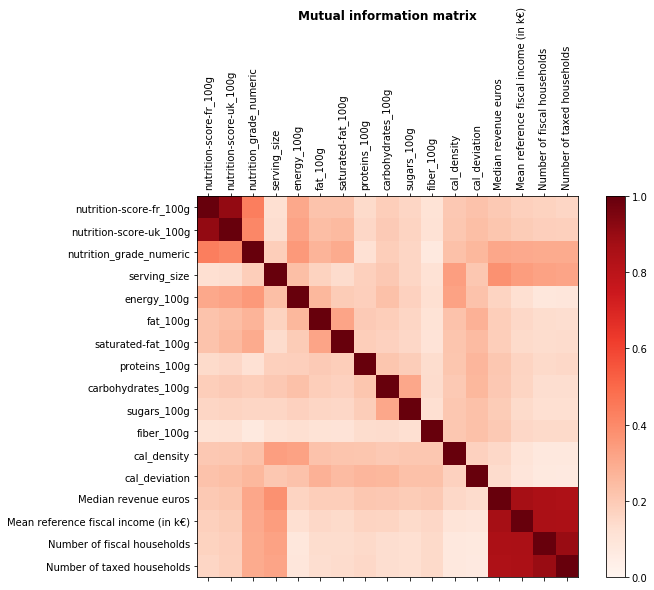

In [112]:
f, ax = plt.subplots(1, 1, figsize=(10, 7))
names = list(mutual_info.columns)
cax = ax.matshow(mutual_info, vmin=0, vmax=1, cmap='Reds')
ticks = np.arange(0, len(new_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title('Mutual information matrix', y=1.45, fontweight='bold')
f.colorbar(cax)
plt.show()

Based on the figure above, we deduce that MI between nutrition-score-fr_100g and nutrition-score-uk_100g is very high leading to the drop of **nutrition-score-uk_100g**. We have also a high dependancy between the last four features meaning that from only one of them (e.g **Median revenue euros**), we can obtain a lot of information about each of the others (**Mean reference fiscal income (in k€), Number of taxed households, Number of fiscal households** ) making us also drop them.

In [38]:
dataframe.drop(columns=['nutrition-score-uk_100g', 'Mean reference fiscal income (in k€)', 
                        'Number of taxed households', 'Number of fiscal households'], inplace=True)

# 5. Aggregation

We have to remove the DOM-TOMS since the cultural differences are too large (Guadeloupe, Guyane, etc).

In [39]:
dom_tom = [1, 2, 4]
dataframe['Region'] = dataframe['Region'][dataframe['Region'].apply(lambda x: x not in dom_tom)]

In [40]:
nutritional_columns = ['nutrition-score-fr_100g', 'nutrition_grade_numeric', 'serving_size',
                       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'proteins_100g', 
                       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'cal_density', 'cal_deviation']
economic_columns = ['Median revenue euros']
geo_columns = ['City','Department', 'Region', 'Arrondissement']

In [42]:
def aggregate(df, area_column):
    drop_cols = geo_columns
    drop_cols.remove(area_column)
    
    mean_df = df.drop(columns=drop_cols).dropna().groupby(area_column).mean()
    median_df = df.drop(columns=drop_cols).dropna().groupby(area_column).median()
    
    return mean_df, median_df

In [43]:
aggregated_city_mean, aggregated_city_med = aggregate(dataframe, 'City') 
aggregated_arrondissement_mean, aggregated_arrondissement_med = aggregate(dataframe, 'Arrondissement') 
aggregated_department_mean, aggregated_department_med = aggregate(dataframe, 'Department') 
aggregated_region_mean, aggregated_region_med = aggregate(dataframe, 'Region') 

# 6. Clustering

We created two dataframes per geographic level, one that aggregates my mean and one that aggregates by median. There are no significant differences between the two of them when we visualize the data. We kept both values for the computation of the correlation, however to check if there are clusters we only kept the dataframe aggregated by the mean.

**1. Cities**

In [49]:
len(nutritional_columns)

12

In [52]:
def plot_scatter(df):
    fig, axs = plt.subplots(3, 4, figsize=(25, 18))
    fig.suptitle("Scatter plots of the relationships between each nutrition attribute and the Median Revenue", 
                fontweight="bold")
    i = 0;
    j = 0;
    count = 1;
    for col in nutritional_columns:
        df.plot.scatter(x='Median revenue euros', y=col, ax=axs[i, j])
        axs[i, j].set_title(col)
        if count % 4 == 0:
            i = i + 1;
        j = (j + 1) % 4;
        count = count + 1
    fig.show()

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


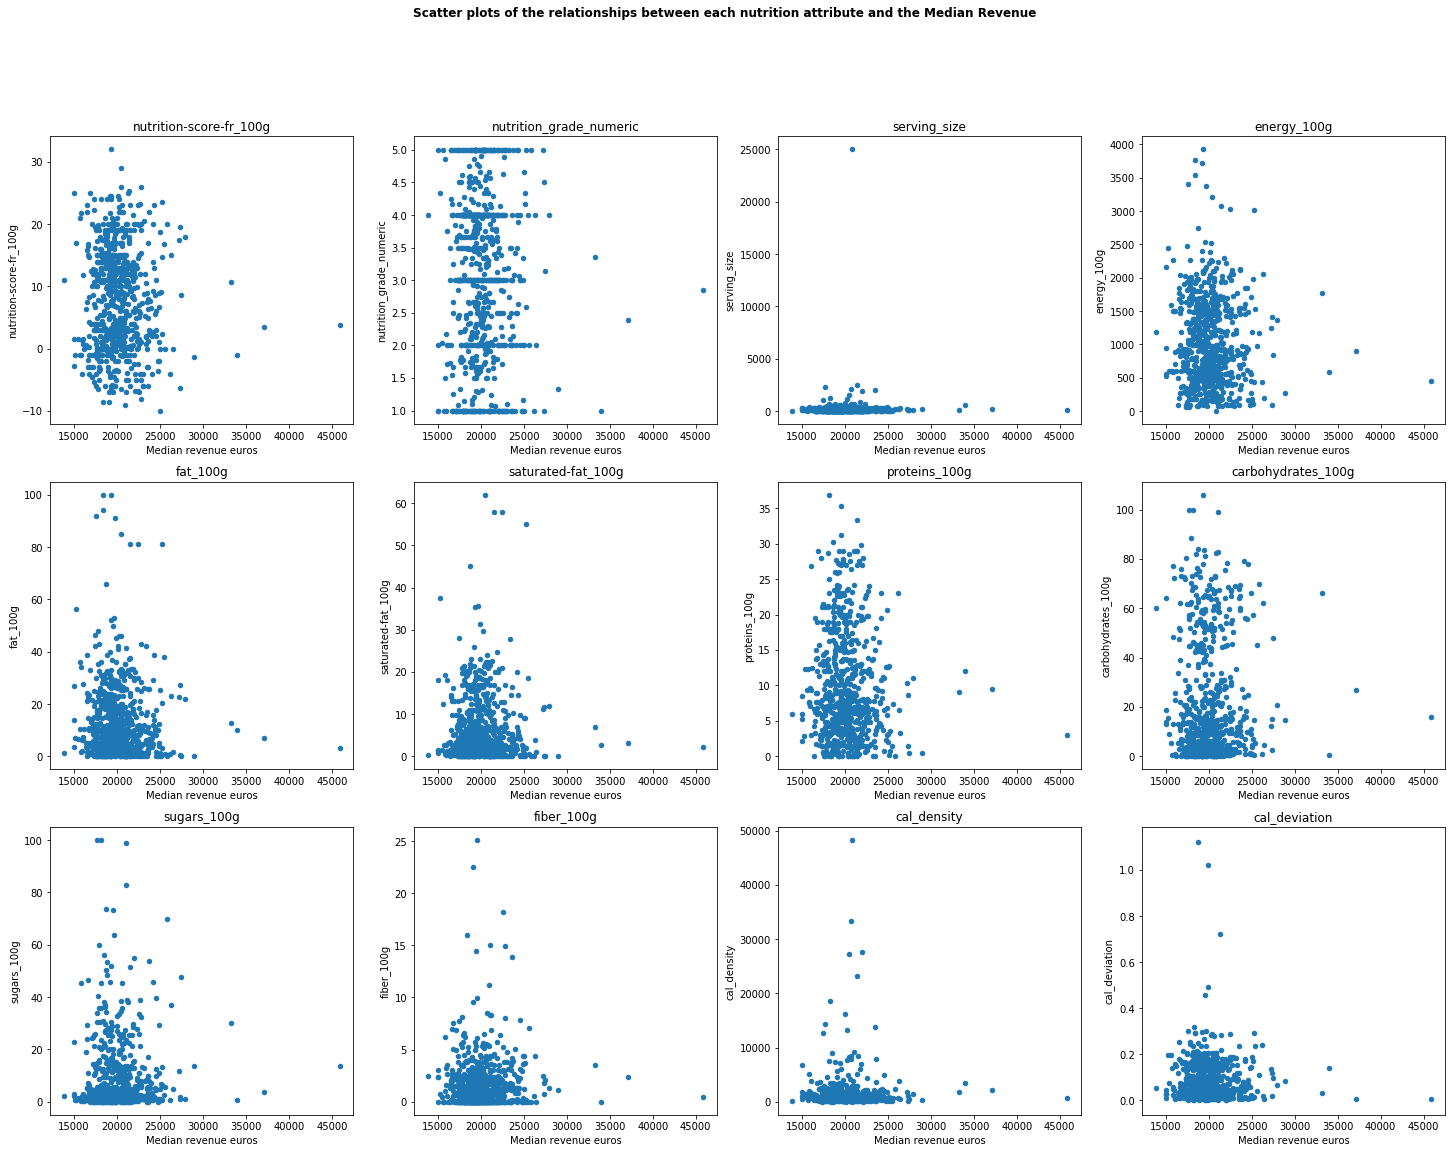

In [53]:
plot_scatter(aggregated_city_mean)

Here we cannot see clear clusters, especially not across different median revenues. The datapoints are all concentrated around 20000 €, and we can see some vague clusters for the graph plotting the **carbohydrates** against **median revenue** (plot (2,4)). The clusters are however not differentiated according to median revenue.

**2. Arrondissements**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


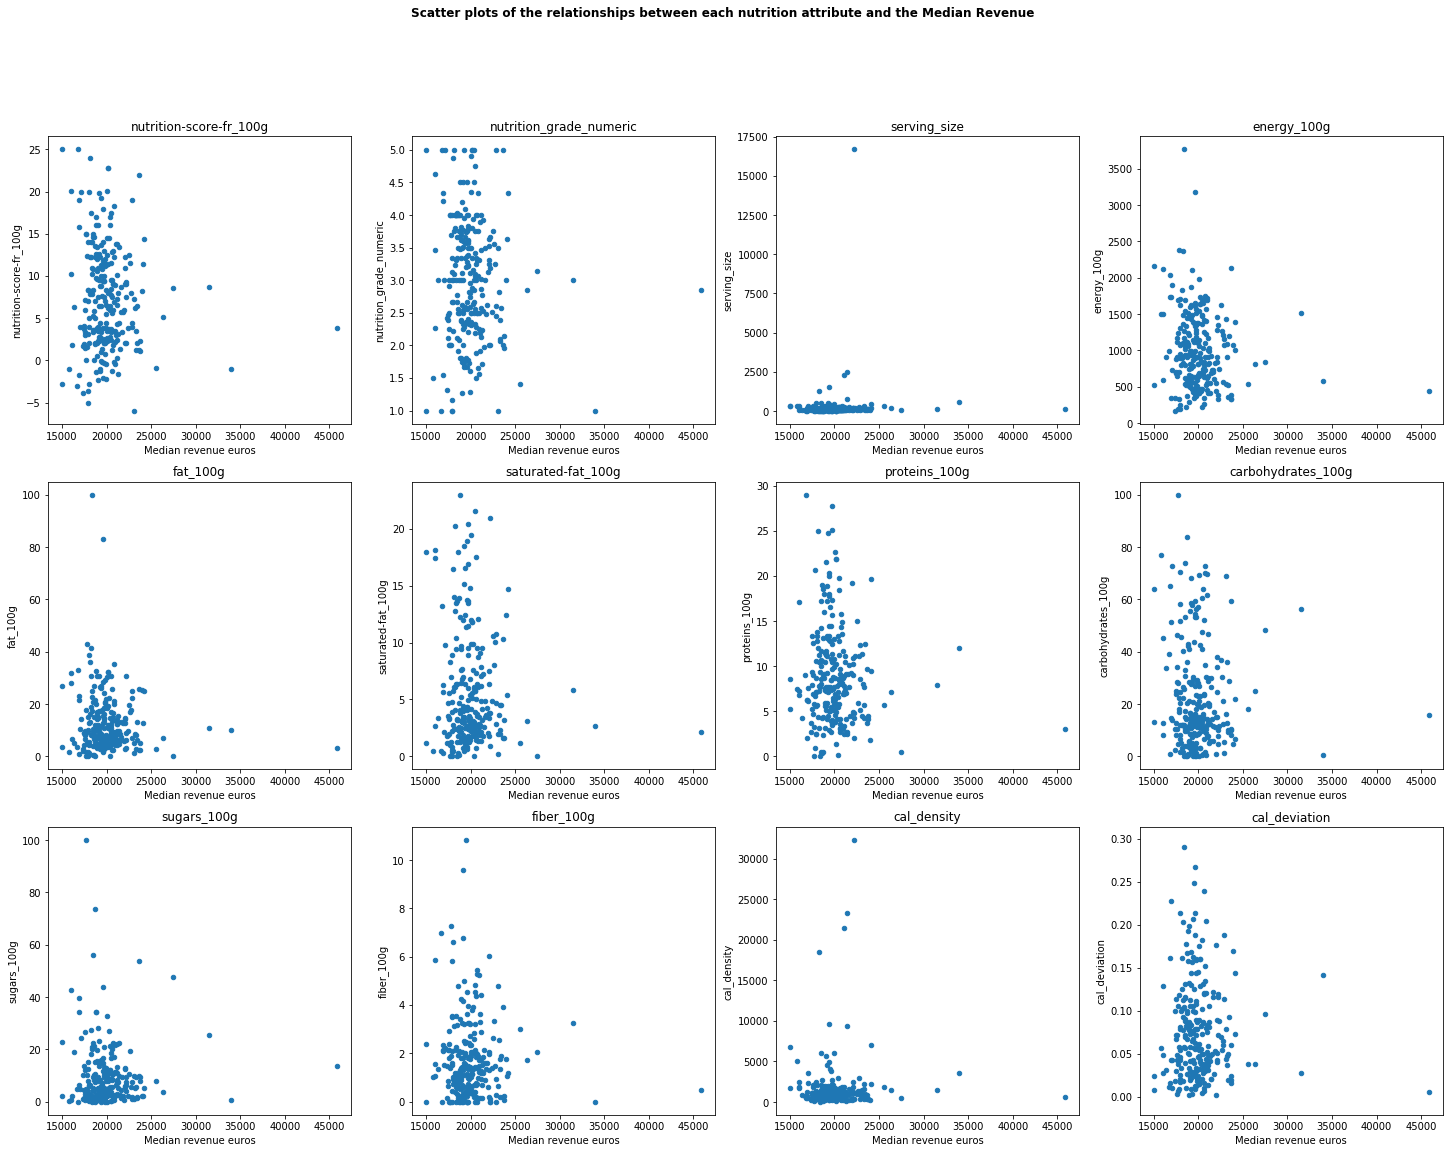

In [55]:
plot_scatter(aggregated_arrondissement_mean)

Same as above, no clear clusters emerge from these scatter plots.

**3. Departments**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


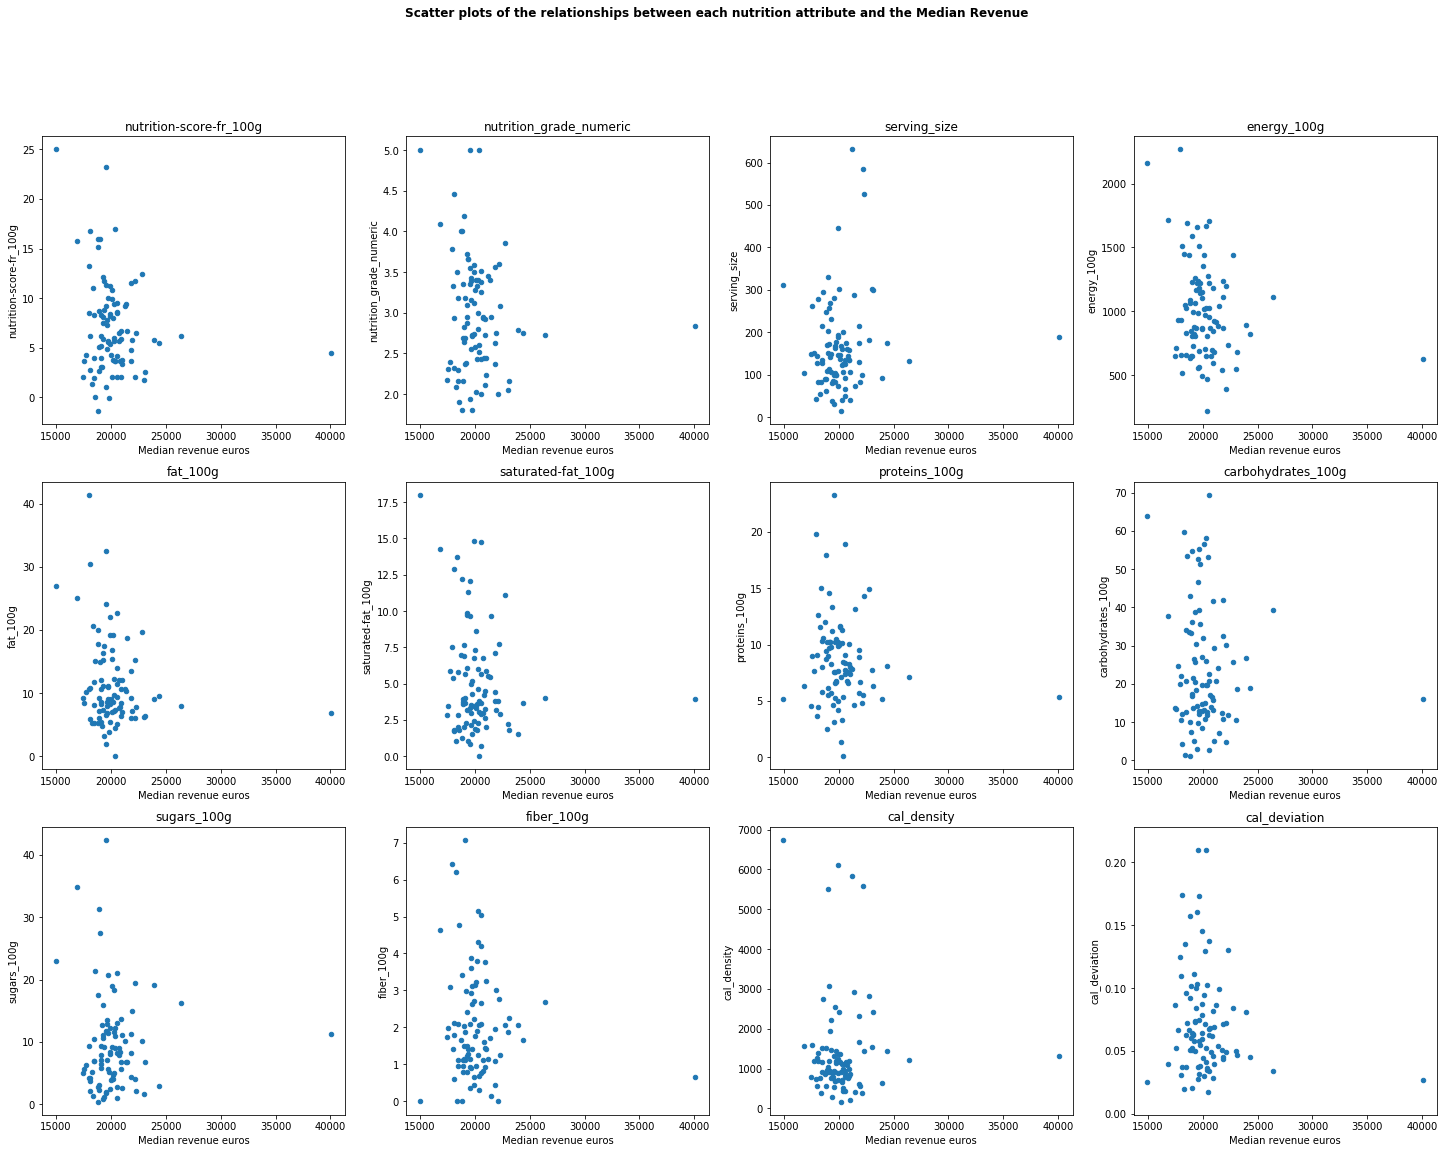

In [57]:
plot_scatter(aggregated_department_mean)

Once again, all blobs are concentrated around 20000€ and we cannot extract actual clusters.

**4. Regions**

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


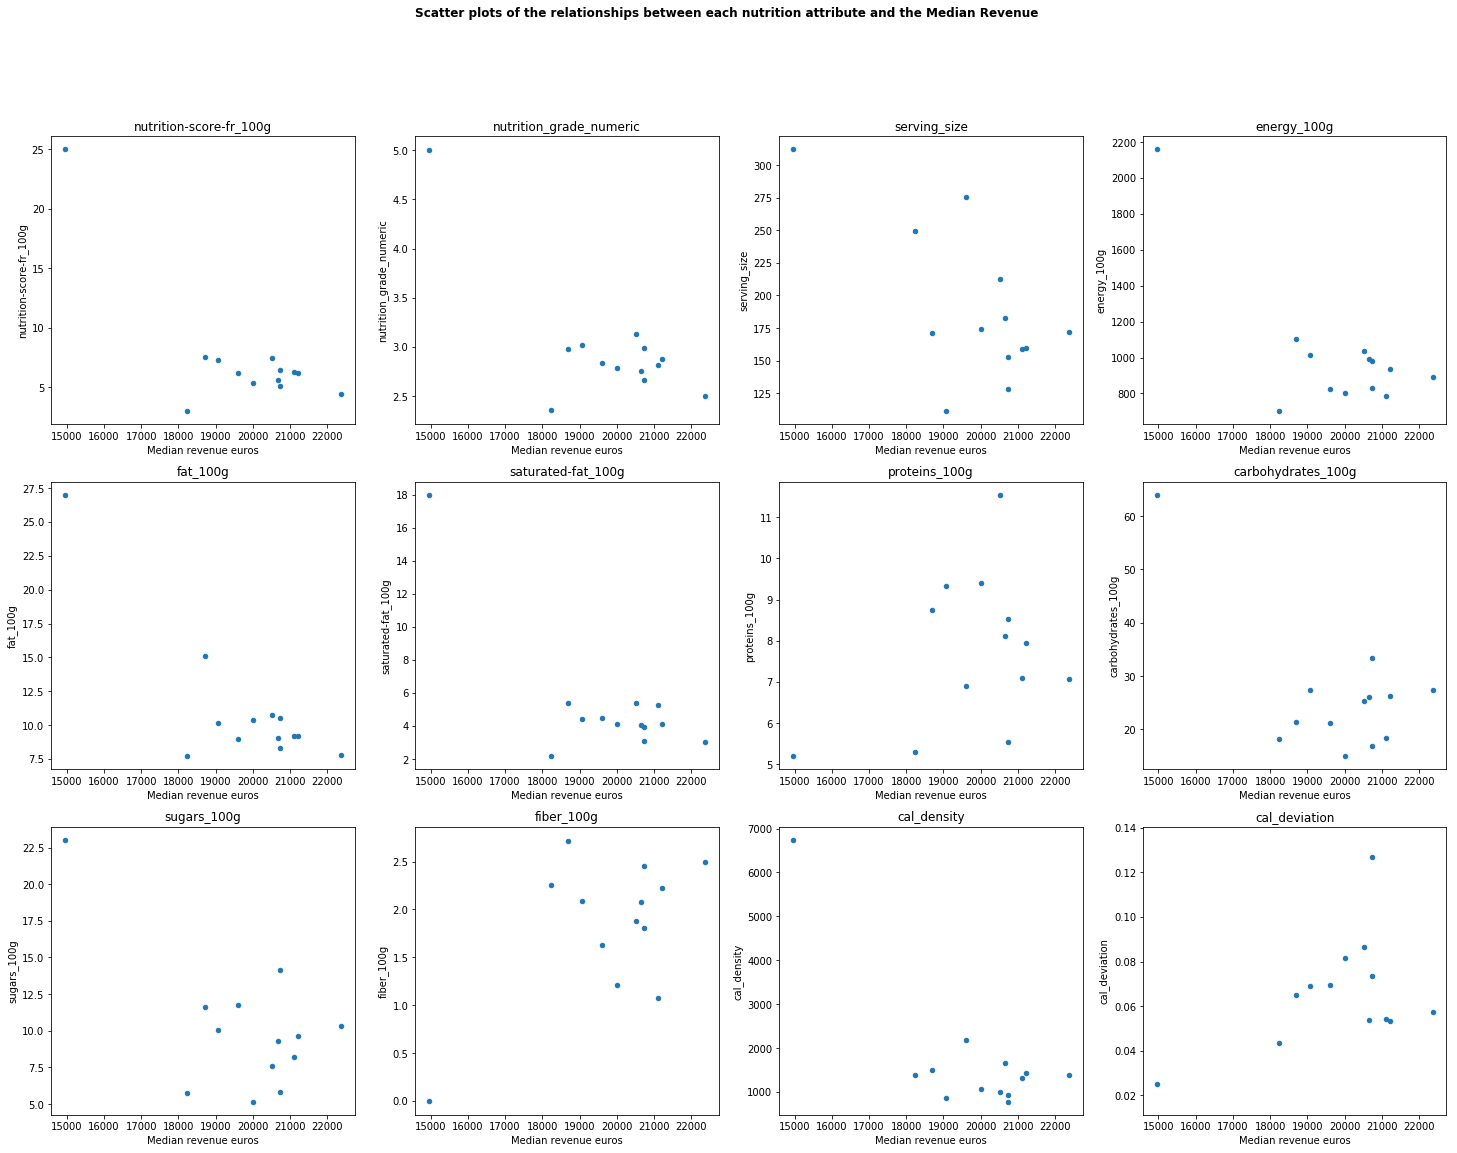

In [59]:
plot_scatter(aggregated_region_mean)

Here, we cannot find clusters but we get a hint of some correlations. These links are explored below. 

In order to make sure that no good clusters can be found, we used DBSCAN with several parameters. We plotted only the results for **nutritional score** against **median revenue** since it was the most significant plot.

In [61]:
def cluster(df, eps, min_samples):
    X = StandardScaler().fit_transform(df)

    # Compute DBSCAN
    db = DBSCAN(eps=0.3, min_samples=10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    if n_clusters_ > 0:
        print("Silhouette Coefficient: %0.3f"
              % metrics.silhouette_score(X, labels))
    else:
        print("Silhouette Coefficient could not be computed for 0 clusters")

    # Plot result
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    return labels

Estimated number of clusters: 1
Estimated number of noise points: 115
Silhouette Coefficient: 0.355


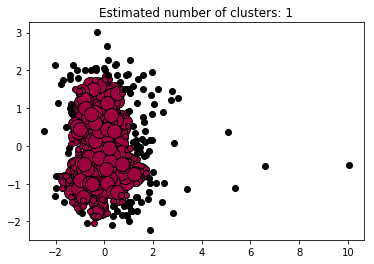

In [62]:
labels = cluster(aggregated_city_mean[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

Estimated number of clusters: 1
Estimated number of noise points: 92
Silhouette Coefficient: 0.377


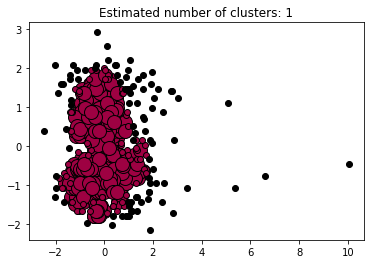

In [63]:
labels = cluster(aggregated_city_med[['Median revenue euros', 'nutrition-score-fr_100g']], 0.3, 1)

Estimated number of clusters: 1
Estimated number of noise points: 74
Silhouette Coefficient: 0.293


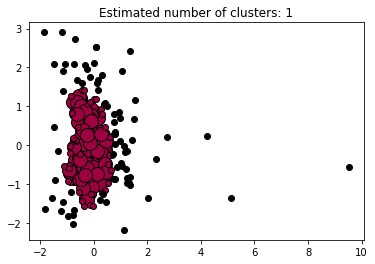

In [64]:
labels = cluster(aggregated_arrondissement_mean[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 10)

Estimated number of clusters: 2
Estimated number of noise points: 65
Silhouette Coefficient: -0.163


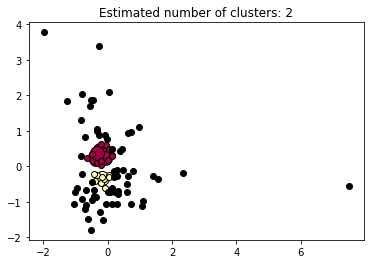

In [65]:
labels = cluster(aggregated_department_mean[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

Estimated number of clusters: 2
Estimated number of noise points: 57
Silhouette Coefficient: -0.046


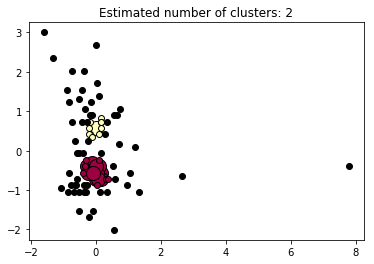

In [66]:
labels = cluster(aggregated_department_med[['Median revenue euros', 'nutrition-score-fr_100g']], 3, 2)

Estimated number of clusters: 0
Estimated number of noise points: 13
Silhouette Coefficient could not be computed for 0 clusters


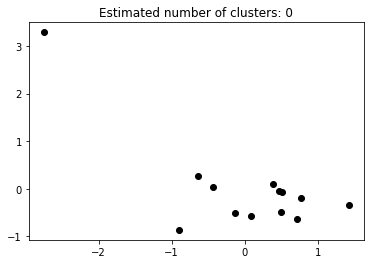

In [67]:
labels = cluster(aggregated_region_mean[['Median revenue euros', 'energy_100g']], 100, 1)

As predicted above, we could not find any meaningful clusters and the maximum Silhouette coefficient that we obtain is around 0.3 (perfect clustering is 1). 

We will hence use linear correlation to explore the links.

# 7. Correlation analysis 

In [69]:
def plot_corr_matrix(df1, df2, geography):
    corr1 = df1.corr()
    corr2 = df2.corr()
    names1 = list(corr1.columns)
    names2 = list(corr1.columns)
    
    # plot correlation matrix
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5.1))
    f.suptitle("Correlation matrix for " + geography, y=1.45, fontweight="bold")
    
    cax1 = ax1.matshow(corr1, vmin=-1, vmax=1)
    ticks1 = np.arange(0, len(names1), 1)
    ax1.set_xticks(ticks1)
    ax1.set_yticks(ticks1)
    ax1.set_xticklabels(names1)
    ax1.set_yticklabels(names1)
    ax1.tick_params(axis='x', labelrotation=90)
    ax1.set_title('Mean', y=1.55)
    
    cax2 = ax2.matshow(corr2, vmin=-1, vmax=1)
    ticks2 = np.arange(0, len(names2), 1)
    ax2.set_xticks(ticks2)
    ax2.set_yticks(ticks2)
    ax2.set_xticklabels(names2)
    ax2.set_yticklabels(names2)
    ax2.tick_params(axis='x', labelrotation=90)
    ax2.set_title('Median', y=1.55)
    
    f.colorbar(cax1)
    plt.show()

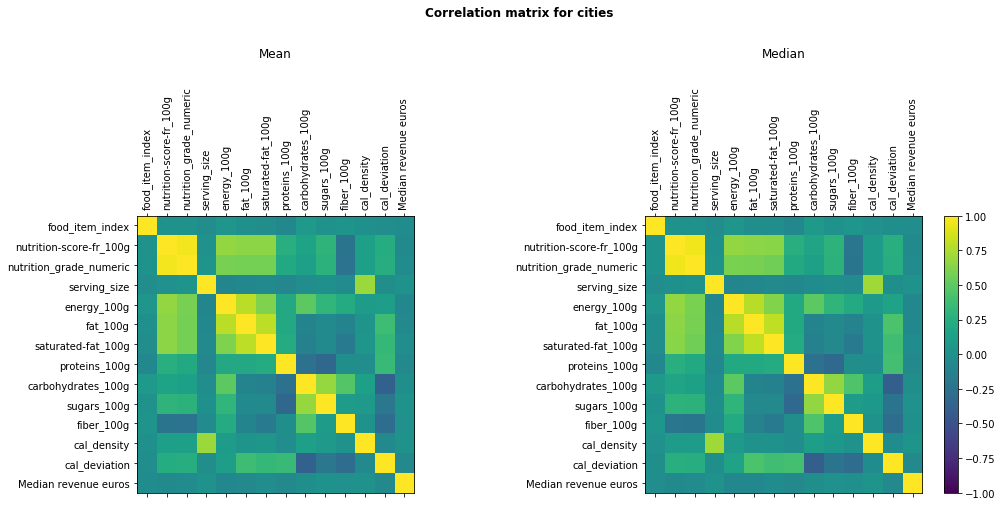

In [70]:
plot_corr_matrix(aggregated_city_mean, aggregated_city_med, "cities")

At a city level, we cannot see much from the correlation matrix. The only correlations that we find are among nutritional features, e.g. the nutrition score and grade (high when unhealthy, low when healthy) is positively correlated with energy, sugars, fat and negatively correlated with fiber. 

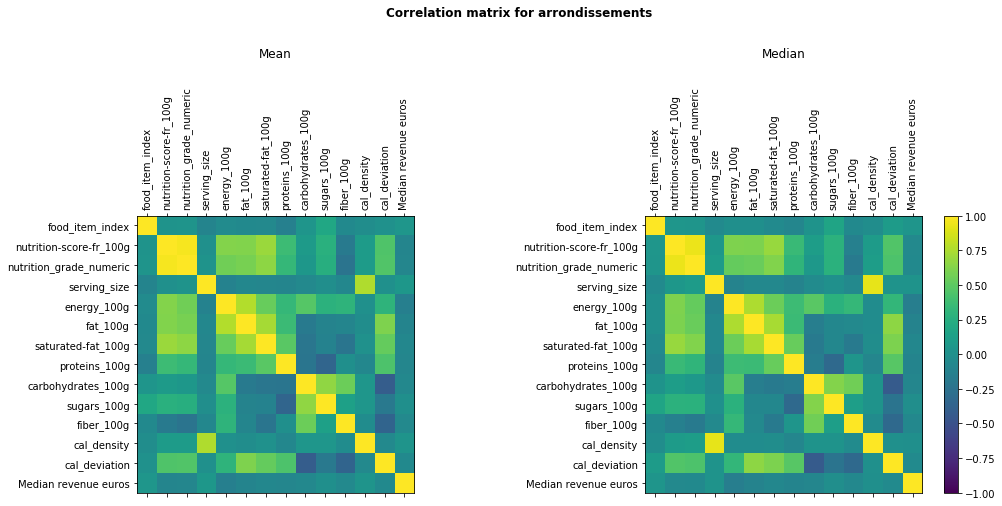

In [71]:
plot_corr_matrix(aggregated_arrondissement_mean, aggregated_arrondissement_med, "arrondissements")

At the arrondissement level, we can also mostly see the correlations between nutritional features. We can however see that the correlation between nutritional score and median revenue is negative, according to the colorbar, but probably not enough to see an actual relation. 

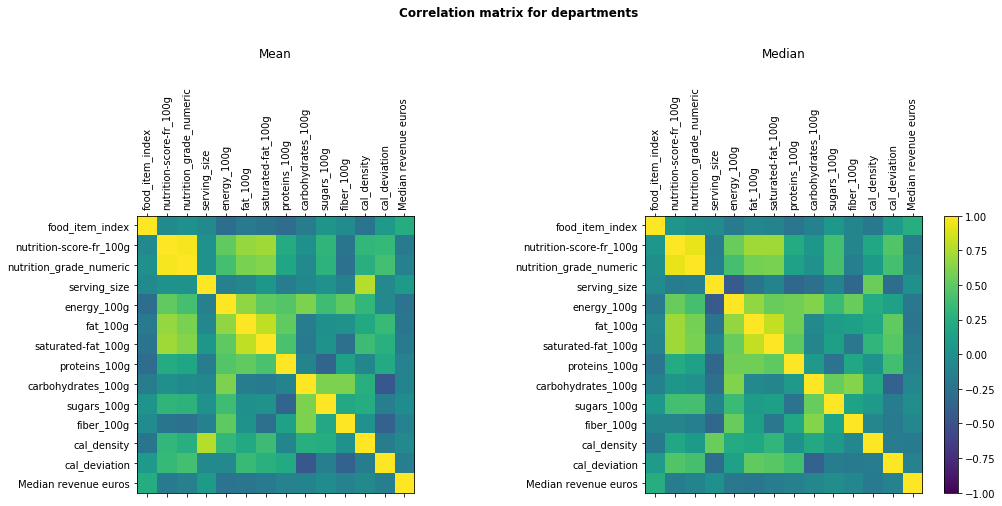

In [72]:
plot_corr_matrix(aggregated_department_mean, aggregated_department_med, "departments")

At the Department level (second largest subdivision of the French territory), the correlations between the nutritional features are more accentuated, especually between nutrition score and energy, fat and saturated fat. We can see that the median revenue column (the last column) has negative correlation values for most of the other features.

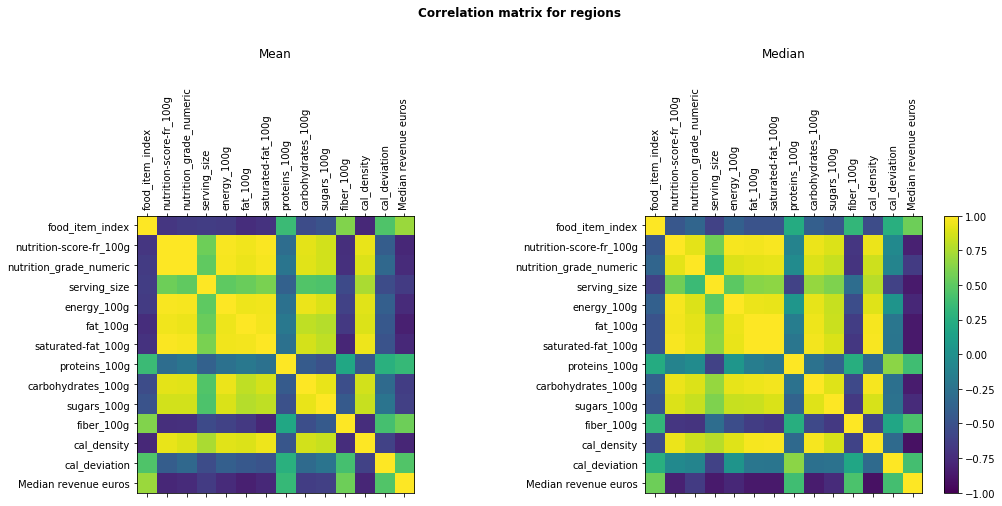

In [73]:
plot_corr_matrix(aggregated_region_mean, aggregated_region_med, "regions")

Hooray, we found something at the region level!

Now we can see that the Median revenue column (the last column) has a strong negative correlation with most of the nutritional features: nutrition score, nutrition grade, serving size, energy, fat, saturated fat, sugars, carbohydrates and calory density. This might indicate that the poorer the region, the worse the qualoty of the available products. This is reinforced by the fact that the Median revenue is positively correlated with the proteins and fiber (richer regions have more available products that have protein and fiber)

Let's see more closely how significant these correlations are:

In [79]:
def pearson_pval_df(df):
    print('Linear correlation between Median revenue and each of the nutritional columns')
    for col in nutritional_columns:
        r, p = stats.pearsonr(df[col], df['Median revenue euros'])
        if p < 0.05:
            color = 'green'
        else:
            color = 'red'
        print(colored('{:<40}{:<16}{:<28.3f}{:<10}{:<30.3f}'.format(col, 'Pearson coeff', r, 'p-value', p), color))

    print('\n')

In [80]:
pearson_pval_df(aggregated_region_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.778                      p-value   0.002                         
nutrition_grade_numeric                 Pearson coeff   -0.756                      p-value   0.003                         
serving_size                            Pearson coeff   -0.650                      p-value   0.016                         
energy_100g                             Pearson coeff   -0.750                      p-value   0.003                         
fat_100g                                Pearson coeff   -0.824                      p-value   0.001                         
saturated-fat_100g                      Pearson coeff   -0.772                      p-value   0.002                         
proteins_100g                           Pearson coeff   0.340                       p-value   0.256                         
carbohydrates_100g                      Pearson

In [81]:
pearson_pval_df(aggregated_region_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.815                      p-value   0.001                         
nutrition_grade_numeric                 Pearson coeff   -0.653                      p-value   0.015                         
serving_size                            Pearson coeff   -0.858                      p-value   0.000                         
energy_100g                             Pearson coeff   -0.775                      p-value   0.002                         
fat_100g                                Pearson coeff   -0.864                      p-value   0.000                         
saturated-fat_100g                      Pearson coeff   -0.863                      p-value   0.000                         
proteins_100g                           Pearson coeff   0.389                       p-value   0.189                         
carbohydrates_100g                      Pearson

From the mean dataframe, the columns for which the correlation with the Median revenue is significant (i.e. the corresponding p-value is below 0.05) are:

* nutrition-score-fr_100g          
* nutrition_grade_numeric  
* serving_size             
* energy_100g              
* fat_100g                 
* saturated-fat_100g   
* sugars_100g
* cal_density          

For all these columns **except for fiber**, we have a negative correlation between each of them and the mean median revenue for the overall region. The Pearson coefficients are all below the -0.3 threshold that allows us to claim that there is a correlation. 
The Pearson coefficients are actually below -0.5 for each of these columns.

The negative correlation is more significant for calory density, fat, saturated fat, the nutrition score and the nutrition grade (coefficient around **-0.7 / -0.8**).

For the median dataframe, we can observe the same tendencies, except that now the correlation between fiber and revenue is no longer significant. 

This might indicate that in poor regions, the food items that are available are richer in fat, sugar, calories and poorer in fiber and proteins. Moreover, the available products in poor regions might have more calories per serving size (this is measured by calory density).

In [82]:
pearson_pval_df(aggregated_department_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.182                      p-value   0.083                         
nutrition_grade_numeric                 Pearson coeff   -0.130                      p-value   0.217                         
serving_size                            Pearson coeff   0.092                       p-value   0.386                         
energy_100g                             Pearson coeff   -0.237                      p-value   0.023                         
fat_100g                                Pearson coeff   -0.211                      p-value   0.043                         
saturated-fat_100g                      Pearson coeff   -0.174                      p-value   0.098                         
proteins_100g                           Pearson coeff   -0.117                      p-value   0.266                         
carbohydrates_100g                      Pearson

In [83]:
pearson_pval_df(aggregated_department_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.158                      p-value   0.133                         
nutrition_grade_numeric                 Pearson coeff   -0.100                      p-value   0.344                         
serving_size                            Pearson coeff   0.004                       p-value   0.968                         
energy_100g                             Pearson coeff   -0.198                      p-value   0.059                         
fat_100g                                Pearson coeff   -0.214                      p-value   0.040                         
saturated-fat_100g                      Pearson coeff   -0.161                      p-value   0.126                         
proteins_100g                           Pearson coeff   -0.125                      p-value   0.235                         
carbohydrates_100g                      Pearson

At a department level, the only meaningful relationships we find is between **revenue** and **evergy and fat**. It is a negative relationship, however the Pearson coefficients are very weak.

In [84]:
pearson_pval_df(aggregated_arrondissement_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.089                      p-value   0.157                         
nutrition_grade_numeric                 Pearson coeff   -0.079                      p-value   0.209                         
serving_size                            Pearson coeff   0.060                       p-value   0.342                         
energy_100g                             Pearson coeff   -0.137                      p-value   0.029                         
fat_100g                                Pearson coeff   -0.096                      p-value   0.129                         
saturated-fat_100g                      Pearson coeff   -0.074                      p-value   0.243                         
proteins_100g                           Pearson coeff   -0.084                      p-value   0.182                         
carbohydrates_100g                      Pearson

In [85]:
pearson_pval_df(aggregated_arrondissement_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.060                      p-value   0.343                         
nutrition_grade_numeric                 Pearson coeff   -0.047                      p-value   0.455                         
serving_size                            Pearson coeff   0.025                       p-value   0.688                         
energy_100g                             Pearson coeff   -0.144                      p-value   0.022                         
fat_100g                                Pearson coeff   -0.104                      p-value   0.097                         
saturated-fat_100g                      Pearson coeff   -0.072                      p-value   0.250                         
proteins_100g                           Pearson coeff   -0.100                      p-value   0.112                         
carbohydrates_100g                      Pearson

At an arrondissement level, we find one significant relationship between calories and revenue. The relationship is negative although the Pearson coefficients are also very weak.

In [86]:
pearson_pval_df(aggregated_city_mean)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.046                      p-value   0.226                         
nutrition_grade_numeric                 Pearson coeff   -0.034                      p-value   0.367                         
serving_size                            Pearson coeff   0.020                       p-value   0.598                         
energy_100g                             Pearson coeff   -0.063                      p-value   0.095                         
fat_100g                                Pearson coeff   -0.061                      p-value   0.102                         
saturated-fat_100g                      Pearson coeff   -0.019                      p-value   0.608                         
proteins_100g                           Pearson coeff   -0.055                      p-value   0.145                         
carbohydrates_100g                      Pearson

In [87]:
pearson_pval_df(aggregated_city_med)

Linear correlation between Median revenue and each of the nutritional columns
nutrition-score-fr_100g                 Pearson coeff   -0.041                      p-value   0.273                         
nutrition_grade_numeric                 Pearson coeff   -0.037                      p-value   0.323                         
serving_size                            Pearson coeff   0.024                       p-value   0.520                         
energy_100g                             Pearson coeff   -0.064                      p-value   0.089                         
fat_100g                                Pearson coeff   -0.064                      p-value   0.089                         
saturated-fat_100g                      Pearson coeff   -0.026                      p-value   0.494                         
proteins_100g                           Pearson coeff   -0.057                      p-value   0.127                         
carbohydrates_100g                      Pearson

Finally, at a city level we cannot extract any meaningful information.

# 8. Geographic visualization

We only found an actual relationship for regions so this is what we're gonna visualize.

First we have to reset the indexes.

In [88]:
aggregated_region_mean.reset_index(inplace=True)
aggregated_region_med.reset_index(inplace=True)

Then we have to transform the 'Region' column from int to string and add a 0 if the region number only has one character.

In [89]:
aggregated_region_mean['Region'] = aggregated_region_mean['Region'].apply(lambda x : "{:0>2}".format(x))
aggregated_region_med['Region'] = aggregated_region_med['Region'].apply(lambda x : "{:0>2}".format(x))

Region borders

In [91]:
# geojson: https://github.com/gregoiredavid/france-geojson
reg_borders = json.load(open("../data/raw/regions-avec-outre-mer.geojson"))

And now the viz:

In [93]:
for column in ['nutrition_grade_numeric', 'nutrition-score-fr_100g']:
    map_nutrition = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
    scale = np.linspace(np.min(aggregated_region_mean[column]), np.max(aggregated_region_mean[column]), 6)
    map_nutrition.choropleth(geo_data=reg_borders, 
                           data=aggregated_region_mean, 
                           columns=['Region', column],
                           key_on='feature.properties.code',
                           legend_name=column,
                           threshold_scale=list(scale),
                           fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                      )

    map_nutrition.save("../data/processed/map_{}.html".format(column))
    display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format(column)))

In [94]:
map_revenue = folium.Map(location=[46.5, 2.3], tiles='cartodbpositron', zoom_start=6)
scale = np.linspace(np.min(aggregated_region_mean['Median revenue euros']), np.max(aggregated_region_mean['Median revenue euros']), 6)
map_revenue.choropleth(geo_data=reg_borders, 
                       data=aggregated_region_mean, 
                       columns=['Region', 'Median revenue euros'],
                       key_on='feature.properties.code',
                       legend_name='Median revenue euros',
                       threshold_scale=list(scale),
                       fill_color='OrRd',fill_opacity=0.7, line_opacity=0.2,
                  )

map_revenue.save("../data/processed/map_{}.html".format('Median revenue euros'))
display(HTML("<a href='../data/processed/map_{0}.html' target='_blank'>{0}</a>".format('Median revenue euros')))